# Análise comparativa entre os itens de projetos culturais
---

Issue: [#172](https://github.com/lappis-unb/salic-ml/issues/172) Razão de Itens Comuns - Evoluir notebook comparando Gaussiana com LOF

## Objetivos

Realizar uma análise comparativa entre os itens de um projeto específico com os itens dos outros projetos culturais de um mesmo segmento. Nesta análise, será investigada a porcentagem de itens de um projeto que estão entre os itens mais frequentes de seu segmento.

---
## Preparação

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
df = pd.read_csv('../../data/raw/planilha_orcamentaria.csv')
print(df.columns)
df.shape

Index(['idPronac', 'PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'Unidade', 'QtDias', 'QtItem', 'nrOcorrencia', 'VlUnitarioSolicitado',
       'VlTotalSolicitado', 'VlUnitarioAprovado', 'VlTotalAprovado', 'UfItem',
       'MunicipioItem', 'Etapa', 'idArea', 'Area', 'idSegmento', 'Segmento',
       'idProduto', 'Produto', 'DataProjeto', 'cdCidade', 'cdEtapa'],
      dtype='object')


(2026756, 25)

#### Gerando tabela com o número de ocorrências de itens por segmento

In [3]:
items = df[['PRONAC', 'idSegmento', 'idPlanilhaItens']].drop_duplicates()
items_occurrences = items.groupby(['idSegmento', 'idPlanilhaItens']).count()
items_occurrences = items_occurrences.rename(columns={'PRONAC': 'itemOccurrences'})
items_occurrences.head()

itemOccurrences
idSegmento idPlanilhaItens                 
11         10                           526
           12                           594
           13                           763
           14                            12
           15                           513

#### Gerando tabela com o número de projetos por segmento

In [4]:
num_projects = items.drop('idPlanilhaItens', axis=1).set_index('idSegmento').drop_duplicates()
num_projects = num_projects.groupby('idSegmento').count()
num_projects = num_projects.rename(columns={'PRONAC': 'numProjects'})
num_projects.head()

,numProjects
idSegmento,
11,9793
12,2415
13,415
14,128
15,4


---
## Desenvolvimento: análise de um projeto

Escolheu-se aleatoriamente um projeto cultural para analisar seus itens com relação aos itens mais comuns de seu segmento.

#### Escolhendo um projeto e gerando sua lista de itens

In [5]:
pronac = 90105
project_items = items[items['PRONAC'] == pronac]
project = project_items.iloc[0]
project_items = project_items.drop(columns=['PRONAC', 'idSegmento'])
project_items = project_items.values[:,0]
project_items

array([  74,   67,   49,   73,   61, 2605,  178,   12,   72,  143, 2620,
         68,   85, 2634,  118,   62,  142,  206,  192,   63,   23,   27,
         71, 2632,   24,  150,   81,  201, 1219, 2692, 2631, 1002,   57,
       1120,   53,   75,  179,   83, 1037, 2715, 2611, 1050, 2667,   66,
       2695,  191,  144, 2633,   40,   22,  117,  189, 2639,  134])

#### Obtendo a lista dos itens do segmento do projeto escolhido e ordenando-os por seus números de ocorrências

(1359, 1)


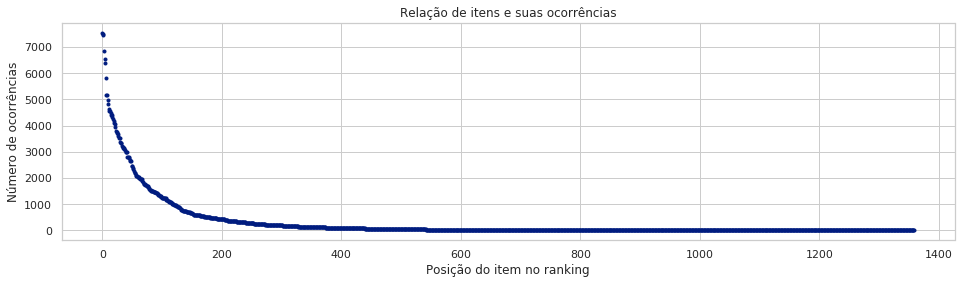

In [6]:
segment = project['idSegmento']
items_segment = items_occurrences.reset_index('idPlanilhaItens').loc[segment]
items_segment = items_segment.reset_index('idSegmento', drop=True)
items_segment = items_segment.set_index('idPlanilhaItens')
items_segment = items_segment.sort_values(by=['itemOccurrences'], ascending=False)
print(items_segment.shape)

sns.set(style='whitegrid', palette='dark')
plt.subplots(figsize=(16,4))
plt.plot(items_segment['itemOccurrences'].values, '.')
plt.title('Relação de itens e suas ocorrências')
plt.ylabel('Número de ocorrências')
plt.xlabel('Posição do item no ranking')
plt.grid(True)

#### Obtendo a lista dos itens mais comuns do segmento

In [7]:
top_items_segment = items_segment.iloc[:len(items_segment)//10]
top_items_segment = top_items_segment.drop(columns=['itemOccurrences'])
top_items_segment = top_items_segment.reset_index('idPlanilhaItens')
print(top_items_segment.shape)
top_items_segment.head()

(135, 1)


,idPlanilhaItens
0,142
1,5249
2,191
3,2743
4,53


#### Calculando a porcentagem de itens do projeto escolhido que estão entre os itens mais comuns

In [8]:
found_in_top = sum(top_items_segment.isin(project_items))[0]
total_items = len(project_items)
print('Itens entre os mais ocorridos: {}'.format(found_in_top))
print('Número de itens do projeto: {}'.format(total_items))
print('Razão: %.2f' % (found_in_top / total_items))

Itens entre os mais ocorridos: 44
Número de itens do projeto: 54
Razão: 0.81


---
## Desenvolvimento: análise por segmento

Escolheu-se aleatoriamente um segmento para analisar a relação entre os itens de cada projeto com os mais comuns do segmento.

#### Definindo funções para encontrar os itens mais comuns de um segmento e calcular as métricas definidas acima

In [9]:
def top_items_segment(segment, percentage=0.1):
    items_segment = items_occurrences.reset_index('idPlanilhaItens').loc[segment]
    items_segment = items_segment.reset_index('idSegmento', drop=True)
    items_segment = items_segment.set_index('idPlanilhaItens')
    items_segment = items_segment.sort_values(by=['itemOccurrences'], ascending=False)
    
    top_items_segment = items_segment.iloc[:int(len(items_segment)*percentage)]
    top_items_segment = top_items_segment.drop(columns=['itemOccurrences'])
    top_items_segment = top_items_segment.reset_index('idPlanilhaItens')

    return top_items_segment

def perc_items_in_top(pronac, top_items_segment):
    project_items = items[items['PRONAC'] == pronac]
    project = project_items.iloc[0]
    project_items = project_items.drop(columns=['PRONAC', 'idSegmento'])
    project_items = project_items.values[:,0]
    
    found_in_top = sum(top_items_segment.isin(project_items))[0]
    total_items = len(project_items)
    
    return found_in_top / total_items

#### Calculando as métricas de porcentagem de itens para todos os projetos do segmento escolhido

In [10]:
segment = '11'
segment_projects = items[items['idSegmento'] == segment]
segment_projects = segment_projects.drop_duplicates(['PRONAC'])
segment_projects = segment_projects['PRONAC'].values
print(len(segment_projects), segment_projects)

%time top_items = top_items_segment(segment)
%time segment_projects = pd.Series([perc_items_in_top(project, top_items) for project in segment_projects])

9793 [100855  97310  90105 ... 124219 133676 170708]
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 27.8 ms
CPU times: user 1min 43s, sys: 168 ms, total: 1min 44s
Wall time: 1min 46s


In [11]:
segment_projects[segment_projects >= 0.999] = 0.999
segment_projects[segment_projects <= 0.001] = 0.001

#### Gerando gráficos dos resultados encontrados

Média da distribuição: 0.79
Desvio padrão da distribuição: 0.14



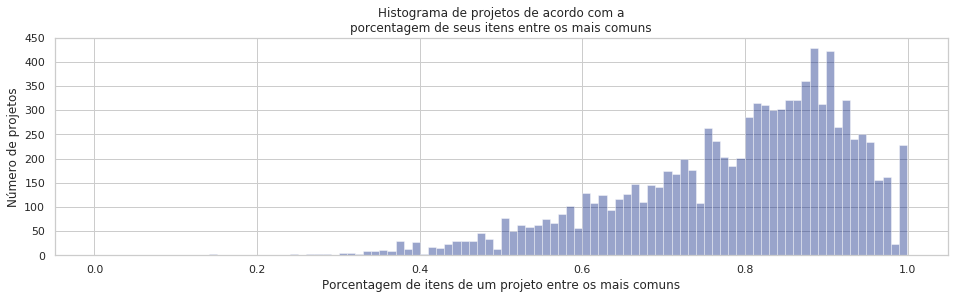

In [12]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(segment_projects, bins=100, kde=False)
plt.title('Histograma de projetos de acordo com a\nporcentagem de seus itens entre os mais comuns')
plt.ylabel('Número de projetos')
plt.xlabel('Porcentagem de itens de um projeto entre os mais comuns')
plt.grid(True)

expected_mean = np.mean(segment_projects)
expected_std = np.std(segment_projects)
print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [13]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

4688    0.700000
3569    0.948718
8317    0.723404
2099    0.937500
2994    0.920000
dtype: float64

6908    0.906977
1799    0.666667
2006    0.681159
7882    0.880000
5335    0.878049
dtype: float64

#### Implementando função auxiliar para mostrar os gráficos e estatísticas referentes a cada um dos modelos explorados

In [14]:
import time
def show_stats(model, train_set, test_set, bin_size=1):
    begin = time.time()
    model.fit(train_set)
    print('Tempo de treinamento: %.3lf (s)' % (time.time() - begin))
    begin = time.time()
    is_inlier = model.predict(test_set)
    print('Tempo de teste: %.3lf (s)' % (time.time() - begin))

    contamination_found = sum(~is_inlier) / len(test_set)
    print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
    print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

    sns.set(style='whitegrid', palette='dark')
    f, ax = plt.subplots(figsize=(16,4))

    inliers = test_set[is_inlier]
    bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
    sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

    outliers = test_set[~is_inlier]
    bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
    sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)
    
    if hasattr(model.model, 'pdf'):
        x = np.linspace(min(test_set), max(test_set), 1000)
        y = model.model.pdf(x)
        if hasattr(model, 'transform'):
            y = model.model.pdf(model.transform(x))
        plt.plot(x,  bin_size * len(test_set) * y, label='PDF')

    plt.legend(frameon=True)
    plt.ylabel('# projects')
    plt.xlabel('% items in the 10% most common of the segment')
    plt.title('Inlier/Outlier division')

#### Implementando funções auxiliares para os modelos utilizados

In [15]:
def bisect(f, a=0, b=1, rtol=1e-6, maxiter=40):
    # simplified scipy.optimize.bisect
    niter, x0 = (0, a)
    while niter < maxiter:
        niter += 1
        x0 = (b + a) / 2
        f0 = f(x0)
        if abs(f0) < rtol:
            break
        elif f0 < 0:
            b = x0
        else:
            a = x0
    return x0

def find_threshold(model, X, contamination):
    h = max(X) - min(X)
    _X = np.linspace(min(X) - h, max(X) + h, int(1e3))
    dx = _X[1] - _X[0]
    pdf = model.pdf(_X)
    def f(threshold):
        _pdf = pdf.copy()
        _pdf[_pdf <= threshold] = 0
        I = scipy.integrate.simps(_pdf, dx=dx)
        return I - (1.0 - contamination)
    return bisect(f)

#### Modelo Gaussiano

Tempo de treinamento: 0.017 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 8.03%


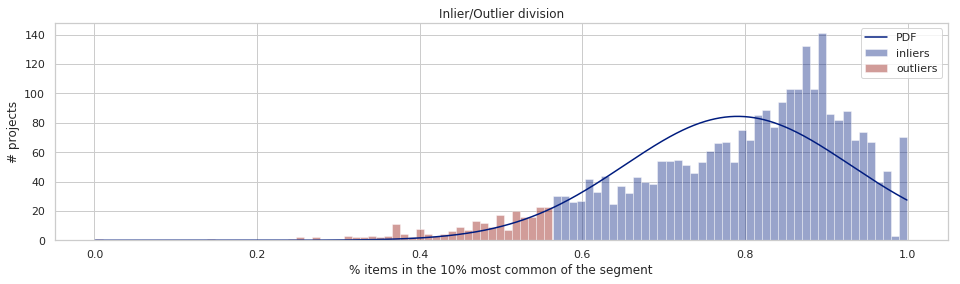

In [16]:
class Gaussian:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Gaussian(), projects_train, projects_test, bin_size=0.01)

#### Modelo Log-normal

Tempo de treinamento: 0.223 (s)
Tempo de teste: 0.003 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 12.66%


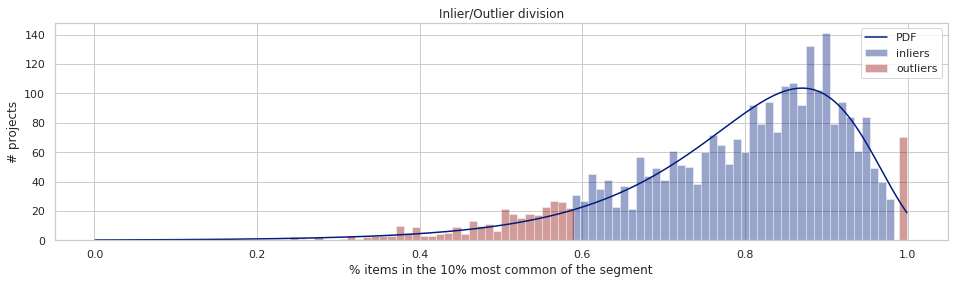

In [17]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=lambda X: X):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        X = self.transform(X)
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Lognormal(transform=lambda X: 1.1-X), projects_train, projects_test, bin_size=0.01)

#### Modelo Gamma

Tempo de treinamento: 0.016 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 6.43%


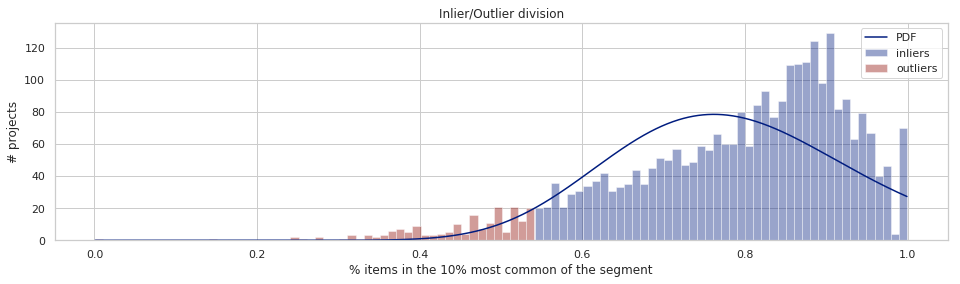

In [18]:
class Gamma:
    def __init__(self, contamination=0.1, transform=lambda X: X):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        X = self.transform(X)
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(Gamma(), projects_train, projects_test, bin_size=0.01)

#### Modelo de Estimativa de Densidade Kernel com Kernel Gaussiano

Tempo de treinamento: 0.935 (s)
Tempo de teste: 1.648 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 8.48%


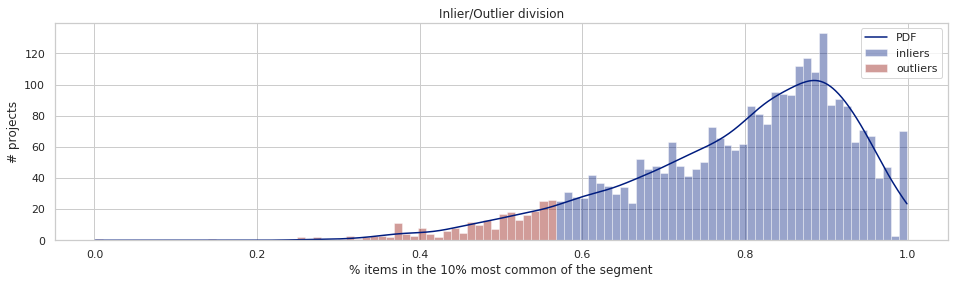

In [19]:
class KDE:
    def __init__(self, contamination=0.1, kernel='gauss'):
        self.contamination = contamination
        self.kernel = kernel

    def fit(self, X):
        # Generate model
        if self.kernel == 'gauss':
            self.model = scipy.stats.gaussian_kde(X)
        else:
            raise AttributeError('Kernel function not found')
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(KDE(), projects_train, projects_test, bin_size=0.01)

#### Estimador por Fator de Anomalia Local (LOF)

Tempo de treinamento: 3.203 (s)
Tempo de teste: 0.023 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 18.72%


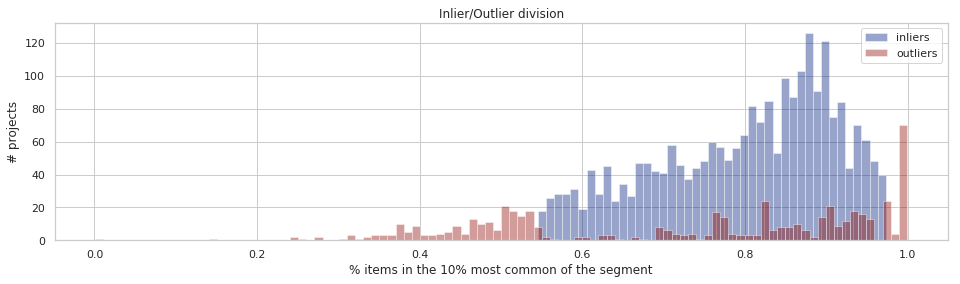

In [20]:
from sklearn.neighbors import LocalOutlierFactor
class LOF:
    def __init__(self, contamination=0.1, n_neighbors=None):
        self.contamination = contamination
        self.n_neighbors = n_neighbors

    def fit(self, X):
        # Transform data into a 2D array
        X = self._1Dto2D(X)
        # Get inliers of the training set with LOF Outlier Detection
        if self.n_neighbors == None:
            self.n_neighbors = len(X) // 5
        lof_OD = LocalOutlierFactor(contamination=self.contamination,
                                    n_neighbors=self.n_neighbors)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]
        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=self.contamination)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

show_stats(LOF(), projects_train, projects_test, bin_size=0.01)

### Avaliando a contaminação para cada um dos métodos

Nesta seção, os diversos modelos implementados acima são aplicados a 100 escolhas diferentes de conjuntos de treino/teste. Ao final, o desempenho de cada método é avaliado.

In [22]:
models = [{
    'name': 'Gaussian',
    'curve': Gaussian(),
    'results': []
},{
    'name': 'Log-normal',
    'curve': Lognormal(transform=lambda X: 1.1-X),
    'results': []
},{
    'name': 'Gamma',
    'curve': Gamma(),
    'results': []
},{
    'name': 'KDE-Gauss',
    'curve': KDE(),
    'results': []
},{
    'name': 'LOF',
    'curve': LOF(),
    'results': []
}]

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)
    
    # Get results for each model
    for model in models:
        inlier_filter = (model['curve'].fit(projects_train).predict(projects_test))
        contamination_found = sum(~inlier_filter) / len(projects_test)
        model['results'].append(100 * contamination_found)

Média Gaussian: 7.82%
Média Log-normal: 12.28%
Média Gamma: 6.19%
Média KDE-Gauss: 9.32%
Média LOF: 19.32%


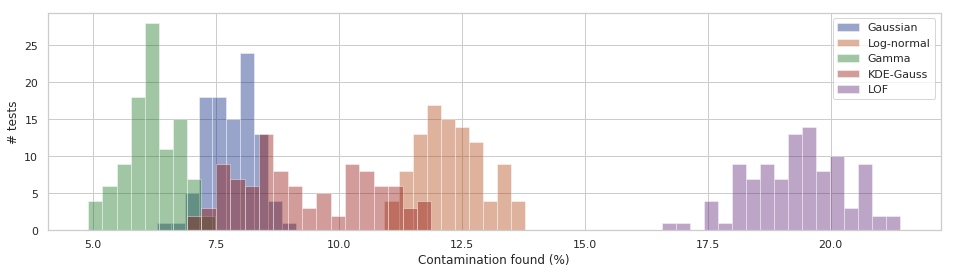

In [23]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.3
for model in models:
    results = model['results']
    print('Média %s: %.2lf%%' % (model['name'], np.mean(results)))
    bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
    sns.distplot(results, label=model['name'], kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

---
## Resultados e Conclusões

Os resultados das 100 execuções de treino e teste realizadas mostram que o modelo de Distribuição KDE obteve o valor mais próximo à contaminação esperada, os modelos Gaussiano e Log-Normal resultados piores, contudo, ainda bastante precisos. O modelo Gamma apresentou, em média, apenas 6% de contaminação, onde a esparada era 10%. O modelo LOF apresentou os piores resultados com, em média, 19.32% de outliers, sendo 10% o esperado.

Em vários modelos, projetos com uma porcentagem muito alta de itens entre os itens mais comuns do segmento foram rotulados como outliers. No modelo LOF, amostras com valores consideravelmente próximos à média da distribuição foram rotuladas como outliers, o que não parece fazer sentido para o contexto.

O modelo KDE apresentou os melhores resultados, porém, com um alto custo computacional. Já os modelos Gaussiano e Log-Normal apresentaram resultados ligeiramente piores, mas com um custo de processamento bem menor. Com isso, todos os três modelos são válidos, cada um com suas vantagens e desvantagens. Os modelos Gamma e LOF tiveram os piores resultados e não são tão adequados para o contexto.

Escolheu-se um segmento e todo o estudo foi realizado com base nos dados daquele único grupo. Um trabalho futuro é a realização das mesmas análises e generalização para os outros segmentos ou produtos culturais.